In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchinfo import summary
import yaml
from tqdm import tqdm
import gc


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)



Device:  cuda


In [35]:
%%writefile config.yaml
Name: "IDL Project"

###### Dataset -----------------------------------------------------------------
root: "dataset.csv"          

NUM_WORKERS: 4
subset: 1       
batch_size: 1

embed_dropout: 0.1

###### Encoder Specs -------------------------------------------------------------
enc_dropout: 0.15
enc_num_layers: 1
enc_num_heads: 8

###### Decoder Specs -------------------------------------------------------------
dec_dropout: 0.15
dec_num_layers: 1
dec_num_heads: 8

###### Network Specs -------------------------------------------------------------
d_model: 256
d_ff: 1024

###### Base Parameters -----------------------------------------------------------
use_wandb: False
use_ctc: False
ctc_weight: 0.3
optimizer: "AdamW" # Adam, AdamW, SGD
momentum: 0.0
nesterov: True
learning_rate: 2E-4
scheduler: "CosineAnnealing" # ['ReduceLR', 'CosineAnnealing']
factor: 0.2
patience: 2
epochs: 100


Overwriting config.yaml


In [3]:
# Load the config file
with open("config.yaml", "r") as file:
  config = yaml.safe_load(file)

In [4]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")  # Change model if needed
max_length = 128

In [15]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class TextDataset(Dataset):
    def __init__(self, 
                 csv_path: str, 
                 isTrainPartition: bool, 
                 tokenizer, 
                 subset: float = 1.0,
                 eos = 1,
                 sos = 1,
                 pad = 0
                 ):
        """
        Args:
            csv_path (str): Path to the CSV file.
            isTrainPartition (bool): Whether the dataset is for training or validation.
            tokenizer: Tokenizer instance to tokenize text.
            subset (float): Fraction of the dataset to use (0.0 to 1.0).
        """
        self.tokenizer = tokenizer
        self.eos_token = eos
        self.sos_token = sos
        self.pad_token = pad
        
        # Load data from CSV
        self.data = pd.read_csv(csv_path)

        # Split into train and validation sets
        split_idx = int(len(self.data) * 0.8)
        if isTrainPartition:
            self.data = self.data.iloc[:split_idx]
        else:
            self.data = self.data.iloc[split_idx:]

        # Apply subset fraction
        subset_idx = int(len(self.data) * subset)
        self.data = self.data.iloc[:subset_idx]

        self.length = len(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        correct_text = row['Correct Text']
        noisy_text = row['Noisy Text']

        # Tokenize texts
        correct_tokens = self.tokenizer.encode(correct_text)
        noisy_tokens = self.tokenizer.encode(noisy_text)

        # Prepare input, target, and golden sequences
        input_seq = torch.LongTensor([self.sos_token] + noisy_tokens + [self.sos_token])
        target_seq = torch.LongTensor([self.sos_token] + correct_tokens)
        golden_seq = torch.LongTensor(correct_tokens + [self.sos_token])

        return input_seq, target_seq, golden_seq

    def collate_fn(self, batch):
        """Collate function for padding and batching."""
        input_seqs = [item[0] for item in batch]
        target_seqs = [item[1] for item in batch]
        golden_seqs = [item[2] for item in batch]

        # Pad sequences
        input_seqs_padded = pad_sequence(input_seqs, batch_first=True, padding_value=self.pad_token)
        target_seqs_padded = pad_sequence(target_seqs, batch_first=True, padding_value=self.pad_token)
        golden_seqs_padded = pad_sequence(golden_seqs, batch_first=True, padding_value=self.pad_token)

        # Get sequence lengths
        input_lengths = torch.tensor([len(seq) for seq in input_seqs])
        target_lengths = torch.tensor([len(seq) for seq in target_seqs])
        golden_lengths = torch.tensor([len(seq) for seq in golden_seqs])

        return input_seqs_padded, target_seqs_padded, golden_seqs_padded, input_lengths, target_lengths, golden_lengths


In [16]:

train_dataset   = TextDataset(
    csv_path        = config['root'],

    tokenizer   = tokenizer,
    isTrainPartition = True,
    subset      = config['subset'],

)


val_dataset     =  TextDataset(
    csv_path        = config['root'],
    tokenizer   = tokenizer,
    isTrainPartition = False,
    subset      = config['subset'],

)





train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = config['NUM_WORKERS'],
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)


val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = config['NUM_WORKERS'],
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn
)




In [ ]:
def verify_dataset(dataloader, partition):
    print("Loaded Path: ", partition)
    max_len_feat = 0
    max_len_t    = 0  

    for batch in tqdm(dataloader, desc=f"Verifying {partition} Dataset"):
      try:
        x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, gold_len = batch

        len_x = x_pad.shape[1]
        if len_x > max_len_feat:
            max_len_feat = len_x


        len_y = y_shifted_pad.shape[1]
        if len_y > max_len_t:
            max_len_t = len_y

      except:
      
        y_shifted_pad, y_golden_pad, y_len = batch

        len_y = y_shifted_pad.shape[1]
        if len_y > max_len_t:
            max_len_t = len_y


    print(f"Maximum Feat Length in Dataset       : {max_len_feat}")
    print(f"Maximum Transcript Length in Dataset : {max_len_t}")
    return max_len_feat, max_len_t

print('')
print("Paired Data Stats: ")
print(f"No. of Train Feats   : {train_dataset.__len__()}")
print(f"Batch Size           : {config['batch_size']}")
print(f"Train Batches        : {train_loader.__len__()}")
print(f"Val Batches          : {val_loader.__len__()}")
print('')
print("Checking the Shapes of the Data --\n")
for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, y_golden_len = batch
    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}")
    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # convert one transcript to text
    transcript = train_dataset.tokenizer.decode(y_shifted_pad[0].tolist())
    print(f"Transcript Shifted: {transcript}")
    transcript = train_dataset.tokenizer.decode(y_golden_pad[0].tolist())
    print(f"Transcript Golden: {transcript}")
    break
print('')


print("\n\nVerifying Datasets")
max_train_input, max_train_transcript = verify_dataset(train_loader, 'train')
max_val_input, max_val_transcript     = verify_dataset(val_loader,   'val')


MAX_INP_LEN = max(max_train_input, max_val_input)
MAX_TRANS_LEN  = max(max_train_transcript, max_val_transcript)
print(f"Maximum Feat. Length in Entire Dataset      : {MAX_INP_LEN}")
print(f"Maximum Transcript Length in Entire Dataset : {MAX_TRANS_LEN}")
print('')
gc.collect()




Paired Data Stats: 
No. of Train Feats   : 800
Batch Size           : 32
Train Batches        : 25
Val Batches          : 7

Checking the Shapes of the Data --

x_pad shape:		torch.Size([32, 124])
x_len shape:		torch.Size([32])
y_shifted_pad shape:	torch.Size([32, 121])
y_golden_pad shape:	torch.Size([32, 121])
y_len shape:		torch.Size([32])

Transcript Shifted: [unused1] [CLS] Kwita ku mirire n [UNK] ubuzima bwo mu mutwe ni ingenzi mu kurushaho kugira ubuzima bwiza. Guharanira gutunga intungamubiri zikwiranye n [UNK] umubiri, gukora imyitozo, no kugira umutima utuje bigira ingaruka nziza ku buzima bw [UNK] umubiri. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Transcript Golden: [CLS] Kwita ku mirire n [UNK] ubuzima bwo mu mutwe ni ingenzi mu kurushaho kugira ubuzima bwiza. Guharanira gutunga intungamubiri zikwiranye n [UNK] umubiri, gukora imyitozo, no kugira umu

Verifying train Dataset: 100%|██████████| 25/25 [00:00<00:00, 67.18it/s]


Maximum Feat Length in Dataset       : 124
Maximum Transcript Length in Dataset : 121
Loaded Path:  val


Verifying val Dataset: 100%|██████████| 7/7 [00:00<00:00, 21.41it/s]

Maximum Feat Length in Dataset       : 39
Maximum Transcript Length in Dataset : 37
Maximum Feat. Length in Entire Dataset      : 124
Maximum Transcript Length in Entire Dataset : 121



1359

In [20]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
      return x + self.pe[:, :x.size(1)]

In [21]:
def PadMask(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

   # If input is a 2D tensor (N/, T), add an extra dimension
    if padded_input.dim() == 2:
        padded_input = padded_input.unsqueeze(-1)

    # Create the mask
    if input_lengths is not None:
        # If lengths are provided, use them to create the mask
        N, T, _ = padded_input.shape
        mask = torch.ones((N, T), dtype=torch.bool)  # Initialize mask to all True (padding)

        for i in range(N):
            mask[i, :input_lengths[i]] = False  # Set non-padding positions to False
    else:
        # Otherwise, infer from the padding index
        mask = (padded_input.squeeze(-1) == pad_idx)  # Shape (N, T)
    return mask



def CausalMask(input_tensor):
    """
    Create an attention mask for causal self-attention based on input lengths and target lengths.

    Args:
        input_tensor (torch.Tensor): The input tensor of shape (N, T, *).

    Returns:
        attn_mask (torch.Tensor): The causal self-attention mask of shape (T, T)
    """
    T = input_tensor.shape[1] # sequence length
    # Self-attention mask: init with all padding
    attn_mask   = torch.zeros(T, T, dtype=torch.bool)  # Shape (T, T)
    causal_mask = ~torch.tril(torch.ones(T, T)).bool() # Lower triangular matrix
    attn_mask   = attn_mask | causal_mask
    # Return single-head attention mask without expanding for multi-head
    return attn_mask





In [36]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.pre_norm = torch.nn.LayerNorm(d_model)
        self.self_attn = torch.nn.MultiheadAttention(embed_dim=d_model,
                                                     num_heads=num_heads,
                                                     dropout=dropout,
                                                     batch_first=True)

      
        self.ffn1 = torch.nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)
   
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)

    def forward(self, x, pad_mask):
        # Self-attention with residual connection and normalization
        residual = x
        x = self.pre_norm(x)
        att_out, att_weights = self.self_attn(query=x, key=x, value=x, need_weights=True, key_padding_mask=pad_mask, is_causal=False)
        x = residual +  self.dropout(att_out)
        x = self.norm1(x)
        residual = x
        # First FFN with residual connection and normalization
        x = residual + self.dropout(self.ffn1(x))
        x = self.norm2(x)
        return x, pad_mask


class Encoder(nn.Module):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 d_ff,
                 max_len,
                 target_vocab_size,
                 dropout=0.1):

        super(Encoder, self).__init__()
        self.pos_encoding = PositionalEncoding(d_model, max_len=max_len)
        self.dropout = nn.Dropout(p=dropout)
        self.inp_embedding       = torch.nn.Embedding(target_vocab_size, d_model)
        self.enc_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
       
        self.after_norm = nn.LayerNorm(d_model, eps=1e-12)
        self.ctc_head   = torch.nn.Linear(d_model, target_vocab_size)


    def forward(self, x, x_len):
        x = self.inp_embedding(x)
        pad_mask = PadMask(padded_input=x, input_lengths=x_len).to(x.device)
        residual = x
        x = self.pos_encoding(x)
        ## Apply Dropout
        x = self.dropout(x)
        # Pass through encoder layers
        x = x + residual
        for layer in self.enc_layers:
            x, pad_mask = layer(x, pad_mask)
        x = self.after_norm(x)
        x_ctc = self.ctc_head(x)
        return x,  x_len, x_ctc.log_softmax(2).permute(1, 0, 2)

In [84]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = nn.MultiheadAttention(embed_dim=d_model,
                                                num_heads=num_heads,
                                                dropout=dropout,
                                                batch_first=True)
        self.mha2       = nn.MultiheadAttention(embed_dim=d_model,
                                                num_heads=num_heads,
                                                dropout=dropout,
                                                batch_first=True)
        self.ffn        = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.identity   = nn.Identity()
        self.pre_norm   = nn.LayerNorm(d_model)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout1   = nn.Dropout(dropout)
        self.dropout2   = nn.Dropout(dropout)
        self.dropout3   = nn.Dropout(dropout)

    def forward(self, padded_targets, enc_output, pad_mask_enc, pad_mask_dec, slf_attn_mask):

  
        x = self.pre_norm(padded_targets)
        residual = x
        mha1_output, mha1_attn_weights = self.mha1(query=x,
                                                   key=x,
                                                   value=x,
                                                   key_padding_mask=pad_mask_dec,
                                                   need_weights=True,
                                                   attn_mask=slf_attn_mask,
                                                   average_attn_weights=True,
                                                   is_causal=True)
        mha1_output = residual + self.dropout1(mha1_output)
        mha1_output = self.layernorm1(mha1_output)


        residual = mha1_output

        
        mha2_output, mha2_attn_weights = self.mha2(query=mha1_output,
                                                key=enc_output,
                                                value=enc_output,
                                                key_padding_mask=pad_mask_enc,
                                                need_weights=True,
                                                average_attn_weights=True,
                                                is_causal=False)

        output = residual + self.dropout2(mha2_output)
        output = self.layernorm2(output)


        ffn_output = self.ffn(output)
        ffn_output = self.dropout3(ffn_output)
        ffn_output = ffn_output + output
        ffn_output = self.layernorm3(ffn_output)


        return ffn_output, mha1_attn_weights, mha2_attn_weights


class Decoder(torch.nn.Module):
    def __init__(self,
                 num_layers,
                 d_model,
                 num_heads,
                 d_ff, dropout,
                 max_len,
                 target_vocab_size):

        super().__init__()

        self.max_len        = max_len
        self.num_layers     = num_layers
        self.num_heads      = num_heads

        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding       = torch.nn.Embedding(target_vocab_size, d_model)
        self.positional_encoding    = PositionalEncoding(d_model=d_model, max_len=max_len)
        self.final_linear           = torch.nn.Linear(d_model, target_vocab_size)
        self.dropout                = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, target_lengths, enc_output, enc_input_lengths):


        pad_mask_dec = None
        if target_lengths is not None:
            pad_mask_dec = PadMask(padded_input=padded_targets, input_lengths=target_lengths).to(padded_targets.device)
        causal_mask = CausalMask(input_tensor=padded_targets).to(padded_targets.device)
        x = self.target_embedding(padded_targets)
        x = self.positional_encoding(x)


        pad_mask_enc = None
        if enc_output is not None:
          pad_mask_enc  = PadMask(padded_input=enc_output, input_lengths=enc_input_lengths).to(enc_output.device)

  
        runnint_att = {}
        for i in range(self.num_layers):
            x, runnint_att['layer{}_dec_self'.format(i + 1)], runnint_att['layer{}_dec_cross'.format(i + 1)] = self.dec_layers[i](padded_targets=x,
                                                                                                                                enc_output=enc_output,
                                                                                                                                pad_mask_enc=pad_mask_enc,
                                                                                                                                pad_mask_dec=pad_mask_dec,
                                                                                                                                slf_attn_mask=causal_mask)

        seq_out = self.final_linear(x)
        return seq_out, runnint_att


    def recognize_greedy_search(self, enc_output, enc_input_lengths, target_output, target_lengths, tokenizer):

        batch_size = target_output.size(0)
        target_seq = torch.full((batch_size, 1), 0, dtype=torch.long).to(target_output.device)
        finished = torch.zeros(batch_size, dtype=torch.bool).to(target_output.device)

        for _ in range(self.max_len):

            seq_out, runnint_att = self.forward(target_seq, None, enc_output, enc_input_lengths)
            logits = torch.nn.functional.log_softmax(seq_out[:, -1], dim=1)


            next_token = logits.argmax(dim=-1).unsqueeze(1)
            target_seq = torch.cat([target_seq, next_token], dim=-1)
            eos_mask = next_token.squeeze(-1) == 0
            finished |= eos_mask
            if finished.all(): break

        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_len - max_length), value=1)

        return target_seq


In [85]:
class Transformer(nn.Module):
    def __init__(self,

                 
                 d_model,
                 enc_num_layers,
                 enc_num_heads,
                 enc_max_len,
                 enc_dropout,

                 dec_num_layers,
                 dec_num_heads,
                 d_ff,
                 dec_dropout,

                 target_vocab_size,
                 trans_max_len):

        super(Transformer, self).__init__()

        

        self.encoder   = Encoder(
            num_layers=enc_num_layers,
            d_model=d_model,
            num_heads=enc_num_heads,
            d_ff=d_ff,
            max_len=enc_max_len,
            target_vocab_size=target_vocab_size,
            dropout=enc_dropout
        )

        self.decoder = Decoder(
            num_layers=dec_num_layers,
            d_model=d_model,
            num_heads=dec_num_heads,
            d_ff=d_ff,
            max_len=trans_max_len,
            target_vocab_size=target_vocab_size,
            dropout=dec_dropout
        )


    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        
        
        encoder_output, encoder_lengths, ctc_out = self.encoder(padded_input, input_lengths)
        

        output, attention_weights = self.decoder(padded_target, target_lengths, encoder_output, encoder_lengths)
        return output, attention_weights, ctc_out


    def recognize(self, inp, inp_len, target, target_len, tokenizer):
        
  
        encoder_output, encoder_lengths, ctc_out = self.encoder(inp, inp_len)
        

        out = self.decoder.recognize_greedy_search(encoder_output, encoder_lengths, target, target_len, tokenizer=tokenizer)
        return out

In [86]:
tokenizer.vocab_size

119547

In [87]:
model = Transformer(
    
    d_model        = config['d_model'],
    enc_num_layers = config['enc_num_layers'],
    enc_num_heads  = config['enc_num_heads'],
    enc_max_len    = MAX_INP_LEN,
    enc_dropout    = config['enc_dropout'],
    dec_num_layers = config['dec_num_layers'],
    dec_num_heads  = config['dec_num_heads'],
    d_ff           = config['d_ff'],
    dec_dropout    = config['dec_dropout'],
    target_vocab_size = tokenizer.vocab_size,
    trans_max_len     = MAX_TRANS_LEN
)

summary(model.to(device), input_data=[x_pad.to(device), x_len.to(device), y_shifted_pad.to(device), y_len.to(device)])

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [32, 121, 119547]         --
├─Encoder: 1-1                                [32, 124, 256]            --
│    └─Embedding: 2-1                         [32, 124, 256]            30,604,032
│    └─PositionalEncoding: 2-2                [32, 124, 256]            --
│    └─Dropout: 2-3                           [32, 124, 256]            --
│    └─ModuleList: 2-4                        --                        --
│    │    └─EncoderLayer: 3-1                 [32, 124, 256]            790,272
│    │    └─EncoderLayer: 3-2                 [32, 124, 256]            790,272
│    │    └─EncoderLayer: 3-3                 [32, 124, 256]            790,272
│    │    └─EncoderLayer: 3-4                 [32, 124, 256]            790,272
│    └─LayerNorm: 2-5                         [32, 124, 256]            512
│    └─Linear: 2-6                            [32, 124, 119547]   

In [88]:
import torchaudio.functional as aF

In [ ]:
def calculateMetrics(reference, hypothesis):
        dist = aF.edit_distance(reference, hypothesis)
        ref_words = reference.split()
        hyp_words = hypothesis.split()
        dist = aF.edit_distance(ref_words, hyp_words)
        wer = dist / len(ref_words)
        ref_chars = list(reference)
        hyp_chars = list(hypothesis)
        dist = aF.edit_distance(ref_chars, hyp_chars)
        cer = dist / len(ref_chars)
        return dist, wer, cer


def calculateBatchMetrics(predictions, y, y_len, tokenizer):
    '''
    Calculate levenshtein distance, WER, CER for a batch
    predictions (Tensor) : the model predictions
    y (Tensor) : the target transcript
    y_len (Tensor) : Length of the target transcript (non-padded positions)
    '''
    batch_size, _  = predictions.shape
    dist, wer, cer = 0., 0., 0.
    for batch_idx in range(batch_size):

        pad_indices = torch.where(predictions[batch_idx] == 1)[0]
        if pad_indices.numel() > 0:
            lowest_pad_idx = pad_indices.min().item()
        else:
            lowest_pad_idx = len(predictions[batch_idx])
        pred_trimmed = predictions[batch_idx, :lowest_pad_idx]


        y_trimmed   = y[batch_idx, 0 : y_len[batch_idx]-1]

        pred_string  = tokenizer.decode(pred_trimmed)
        y_string     = tokenizer.decode(y_trimmed)

        curr_dist, curr_wer, curr_cer = calculateMetrics(y_string, pred_string)
        dist += curr_dist
        wer  += curr_wer
        cer  += curr_cer

    dist /= batch_size
    wer  /= batch_size
    cer  /= batch_size
    return dist, wer, cer, y_string, pred_string

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def save_attention_plot(plot_path, attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''
    plt.clf() 
    sns.heatmap(attention_weights, cmap="viridis")  # Create heatmap

    if epoch<100:
        plt.savefig(f"{plot_path}/cross_attention-epoch{epoch}.png")
    else :
        plt.savefig(f"{plot_path}/self_attention-epoch{epoch-100}.png")



def save_model(model, optimizer, scheduler, metric, epoch, path):
      torch.save(
          {"model_state_dict"        : model.state_dict(),
          "optimizer_state_dict"     : optimizer.state_dict(),
          "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
          metric[0]                  : metric[1],
          "epoch"                    : epoch},
          path
      )


def load_checkpoint(checkpoint_path,
                    model,
                    embedding_load:bool,
                    encoder_load:bool,
                    decoder_load:bool):
 
    checkpoint = torch.load(checkpoint_path)

    model_state_dict = model.state_dict()
    embedding_state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith("embedding")}
    encoder_state_dict   = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith("encoder")}
    decoder_state_dict   = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith("decoder")}

    if embedding_load:
      model_state_dict.update(embedding_state_dict)
    if encoder_load:
      model_state_dict.update(encoder_state_dict)
    if decoder_load:
      model_state_dict.update(decoder_state_dict)

    model.load_state_dict(model_state_dict, strict=False)
    s0 = "Embedding" if embedding_load else ""
    s1 = "Encoder" if encoder_load else ""
    s2 = "Decoder" if decoder_load else ""
    print("Loaded: ", f'{s0}, {s1}, {s2}')

In [ ]:
def train_step(model,
               criterion,
               ctc_loss,
               ctc_weight,
               optimizer,
               scheduler,
               scaler,
               device,
               train_loader,
               tokenizer):

        model.train()
        batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0)

        running_loss        = 0.0
        running_perplexity  = 0.0

        for i, batch in enumerate(train_loader):

            optimizer.zero_grad()
           
            inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths, _ = batch
            inputs          = inputs.to(device)
        
            targets_shifted = targets_shifted.to(device)
            targets_golden  = targets_golden.to(device)

            with torch.autocast(device_type=device, dtype=torch.float16):
                raw_predictions, attention_weights, ctc_out = model(inputs, inputs_lengths, targets_shifted, targets_lengths)
                padding_mask = torch.logical_not(torch.eq(targets_shifted, 1))

                loss = criterion(raw_predictions.transpose(1,2), targets_golden)*padding_mask
                loss = loss.sum() / padding_mask.sum()

                if ctc_loss is not None and ctc_out is not None:
                  inputs_lengths = torch.ceil(inputs_lengths.float() / model.embedding.time_downsampling_factor).int()
                  inputs_lengths = inputs_lengths.clamp(max=ctc_out.size(0))
                  loss = loss + ctc_weight * ctc_loss(ctc_out, targets_golden, inputs_lengths, targets_lengths)

            scaler.scale(loss).backward() 
            scaler.step(optimizer)        
            scaler.update()             
            perplexity           = torch.exp(loss)
            running_perplexity  += perplexity.item()

            batch_bar.set_postfix(
                loss = "{:.04f}".format(float(running_loss / (i + 1))),
                perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
            )

            batch_bar.update()

            del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
            torch.cuda.empty_cache()

        running_loss        = float(running_loss / len(train_loader))
        running_perplexity  = float(running_perplexity / len(train_loader))
        batch_bar.close()
        return running_loss, running_perplexity, attention_weights



def validate_step(model, val_loader, tokenizer, device,  threshold=5):
      model.eval()
      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

      running_distance = 0.0
      running_wer = 0.0
      running_cer = 0.0
      json_output = {}

      for i, batch in enumerate(val_loader):

          
            inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths, _ = batch
            inputs          = inputs.to(device)
            
            targets_shifted = targets_shifted.to(device)
            targets_golden  = targets_golden.to(device)

            with torch.inference_mode():
                greedy_predictions = model.recognize(inputs, inputs_lengths, targets_shifted, targets_lengths, tokenizer=tokenizer)

            dist, wer, cer, y_string, pred_string = calculateBatchMetrics(greedy_predictions, targets_golden, targets_lengths, tokenizer)
            running_distance += dist
            running_wer += wer
            running_cer += cer

            json_output[i] = {
                "Input": y_string,
                "Output": pred_string
            }

            batch_bar.set_postfix(
                running_distance = "{:.04f}".format(float(running_distance / (i + 1))),
                WER = "{:.04f}".format(float(running_wer / (i + 1))),
                CER = "{:.04f}".format(float(running_cer / (i + 1)))
            )

            batch_bar.update()

            del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
            torch.cuda.empty_cache()

            if threshold is not None:
                if i==threshold: break      # validating only upon first five batches

      batch_bar.close()
      if threshold is not None:
        running_distance /= (threshold+1)
        running_wer /= (threshold+1)
        running_cer /= (threshold+1)
      else:
        running_distance /= len(val_loader)
        running_wer /= len(val_loader)
        running_cer /= len(val_loader)

      return running_distance, json_output, running_wer, running_cer

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = 1)
ctc_loss_fn  = None
if config['use_ctc']:
  ctc_loss_fn = nn.CTCLoss(blank=1)
scaler      = torch.cuda.amp.GradScaler()

def get_optimizer():
    optimizer = None
    if config["optimizer"] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=config["learning_rate"],
                                    momentum=config["momentum"],
                                    weight_decay=1E-4,
                                    nesterov=config["nesterov"])

    elif config["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(),
                                    lr=float(config["learning_rate"]),weight_decay=0.01 )

    elif config["optimizer"] == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(),
                                    lr=float(config["learning_rate"]),
                                    weight_decay=0.01)
    return optimizer
optimizer = get_optimizer()
assert optimizer!=None

def get_scheduler():
    scheduler  =  None
    if config["scheduler"] == "ReduceLR":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                        factor=config["factor"], patience=config["patience"], min_lr=1E-8, threshold=1E-1)

    elif config["scheduler"] == "CosineAnnealing":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                        T_max = config["epochs"], eta_min=1E-8)
    return scheduler

scheduler = get_scheduler()
assert scheduler!=None

/tmp/ipykernel_449302/2603785494.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler      = torch.cuda.amp.GradScaler()


In [ ]:
import os
import wandb
import shutil
USE_WANDB = False
RESUME_LOGGING = False


run_name = "Proj-{}-{}_DEC-{}-{}_{}_{}_{}_{}_token_greedy".format(
    config["Name"],
    config["enc_num_layers"],
    config["enc_num_heads"],
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
   
    )

expt_root = os.path.join(os.getcwd(), run_name)
os.makedirs(expt_root, exist_ok=True)

if USE_WANDB:
    wandb.login(key="enter_your_key", relogin=True) 

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        
            resume = True,         
            project = "IDL Project",  
        )

    else:
        run = wandb.init(
            name    = run_name,    
            reinit  = True,       
            project = "Project", 
            config  = config       
        )

        model_arch  = str(model)
        ### Save it in a txt file
        model_path = os.path.join(expt_root, "model_arch.txt")
        arch_file   = open(model_path, "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()


shutil.copy(os.path.join(os.getcwd(), 'config.yaml'), os.path.join(expt_root, 'config.yaml'))
e                   = 0
best_loss           = 10.0
best_perplexity     = 10.0
best_dist = 60
RESUME_LOGGING = False
checkpoint_root = os.path.join(expt_root, 'checkpoints')
text_root       = os.path.join(expt_root, 'out_text')
attn_img_root   = os.path.join(expt_root, 'attention_imgs')
os.makedirs(checkpoint_root, exist_ok=True)
os.makedirs(attn_img_root,   exist_ok=True)
os.makedirs(text_root,       exist_ok=True)
checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)


if USE_WANDB:
    wandb.watch(model, log="all")

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

1607

In [103]:
import json


Epoch 1/100



Epoch 1/100: 
Train Loss 2.1268	 Train Perplexity 8.7983	 Learning Rate 0.000200


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 2/100



Epoch 2/100: 
Train Loss 1.3489	 Train Perplexity 3.9324	 Learning Rate 0.000200


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 3/100



Epoch 3/100: 
Train Loss 0.7955	 Train Perplexity 2.2381	 Learning Rate 0.000200


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 4/100



Epoch 4/100: 
Train Loss 0.4339	 Train Perplexity 1.5495	 Learning Rate 0.000200


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 5/100



Epoch 5/100: 
Train Loss 0.2359	 Train Perplexity 1.2671	 Learning Rate 0.000199


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 6/100



Epoch 6/100: 
Train Loss 0.1420	 Train Perplexity 1.1529	 Learning Rate 0.000199


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 7/100



Epoch 7/100: 
Train Loss 0.0934	 Train Perplexity 1.0980	 Learning Rate 0.000198


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 8/100



Epoch 8/100: 
Train Loss 0.0684	 Train Perplexity 1.0708	 Learning Rate 0.000198


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 9/100



Epoch 9/100: 
Train Loss 0.0535	 Train Perplexity 1.0550	 Learning Rate 0.000197


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 10/100



Epoch 10/100: 
Train Loss 0.0434	 Train Perplexity 1.0444	 Learning Rate 0.000196


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 11/100



Epoch 11/100: 
Train Loss 0.0364	 Train Perplexity 1.0371	 Learning Rate 0.000195


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 12/100



Epoch 12/100: 
Train Loss 0.0309	 Train Perplexity 1.0314	 Learning Rate 0.000194


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 13/100



Epoch 13/100: 
Train Loss 0.0271	 Train Perplexity 1.0275	 Learning Rate 0.000193


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759

Epoch 14/100



Epoch 14/100: 
Train Loss 0.0239	 Train Perplexity 1.0242	 Learning Rate 0.000192


Levenshtein Distance : 82.0365
WER                  : 1.0000
CER                  : 0.9759


KeyboardInterrupt: 

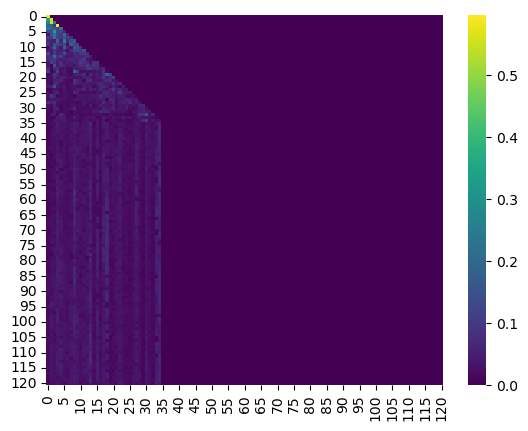

In [ ]:
gc.collect()
torch.cuda.empty_cache()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_step(
        model,
        criterion=loss_func,
        ctc_loss=ctc_loss_fn,
        ctc_weight=config['ctc_weight'],
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=device,
        train_loader=train_loader,
        tokenizer=tokenizer,
    )

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.06f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))


    levenshtein_distance, json_out, wer, cer = validate_step(
        model,
        val_loader=val_loader,
        tokenizer=tokenizer,
        device=device,
        threshold=5
    )


    fpath = os.path.join(text_root, f'full_{epoch+1}_out.json')
    with open(fpath, "w") as f:
        json.dump(json_out, f, indent=4)

    print("Levenshtein Distance : {:.04f}".format(levenshtein_distance))
    print("WER                  : {:.04f}".format(wer))
    print("CER                  : {:.04f}".format(cer))

    attention_keys = list(attention_weights.keys())
    attention_weights_decoder_self   = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross  = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    if USE_WANDB:
        wandb.log({
            "train_loss"       : train_loss,
            "train_perplexity" : train_perplexity,
            "learning_rate"    : curr_lr,
            "lev_dist"         : levenshtein_distance,
            "WER"              : wer,
            "CER"              : cer
        })


    save_attention_plot(str(attn_img_root), attention_weights_decoder_cross, epoch )
    save_attention_plot(str(attn_img_root), attention_weights_decoder_self, epoch+100)
    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)

    if best_dist >= levenshtein_distance:
        best_loss = train_loss
        best_dist = levenshtein_distance
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        print("Saved best distance model")


if USE_WANDB:
    run.finish()


In [ ]:
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
processor = AutoProcessor.from_pretrained("mbazaNLP/Whisper-Small-Kinyarwanda")
model_whisper = AutoModelForSpeechSeq2Seq.from_pretrained("mbazaNLP/Whisper-Small-Kinyarwanda")
model_whisper.config.forced_decoder_ids = None
model_whisper.config.suppress_tokens = None

whisper_pipe = pipeline(
    "automatic-speech-recognition",
    model=model_whisper,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,

    device="cuda",   

)

def predict(model, audio, tokenizer):
    out = whisper_pipe(audio)

    noisy_text = out['text']
    model.eval()
    input = tokenizer.encode(noisy_text)
    greedy_predictions = model.recognize(input, [len(input)], tokenizer=tokenizer)

   
    
    pad_indices = torch.where(greedy_predictions[0] == 1)[0]
    if pad_indices.numel() > 0:
        lowest_pad_idx = pad_indices.min().item()
    else:
        lowest_pad_idx = len(greedy_predictions[0])
    pred_trimmed = greedy_predictions[0, :lowest_pad_idx]
    
    pred_string  = tokenizer.decode(pred_trimmed)



    return pred_string

In [ ]:
import pandas as pd

# Create data for transcripts
transcripts = [
    "Imiti yo kuvura kanseri ikunze kugira ingaruka zikomeye ku murwayi.",
    "Guhuza imirire myiza n'imyitozo ngororamubiri byongera ubuzima bwiza.",
    "Ubwandu bw'igituntu bukomeje kuba ikibazo cy'ubuzima rusange mu bihugu biri mu nzira y'amajyambere.",
    "Ubuvuzi bw'amenyo bukwiye guhabwa umwanya uhagije mu buvuzi rusange.",
    "Urukingo rwa COVID-19 rwagaragaje umusaruro mwiza mu kugabanya ubukana.",
    "Ubushakashatsi bwerekana ko kugabanya umunyu bigabanya ibyago byo kurwara umutima.",
    "Kubyara kare bishobora kugira ingaruka mbi ku buzima bw'umubyeyi n'umwana.",
    "Abantu benshi batitabira gupimwa indwara zitandura nka diyabete.",
    "Ubuvuzi bwa kinyarwanda bufite umwanya wihariye mu muryango nyarwanda.",
    "Gukoresha ikoranabuhanga mu buvuzi byongereye ubudahangarwa mu kwita ku barwayi.",
    "Imibereho y'abantu igira uruhare runini mu gutegura ubuvuzi bukwiye.",
    "Kurwanya malariya bisaba ubufatanye bw'inzego zose z'ubuzima.",
    "Ubusumbane mu buvuzi bukomeje kuba imbogamizi ikomeye.",
    "Itabi rikomeje kuba intandaro y'indwara z'umutima n'ibihaha.",
    "Kwita ku buzima bwo mu mutwe bikwiye kuba mu by'ibanze mu buvuzi.",
    "Imirire idahwitse ikomeje kuba ikibazo mu bana bato.",
    "Kuboneza urubyaro ni ingenzi mu kugabanya umubare w'abaturage.",
    "Ubukangurambaga ku buzima bw'imyororokere burakenewe mu rubyiruko.",
    "Amavuriro y'ibanze akwiye guhabwa ibikoresho bihagije.",
    "Ubuvuzi bw'amatungo bufitanye isano ya hafi n'ubuzima bw'abantu.",
    "Kugabanya ibiro birakenewe ku bantu bafite umubyibuho ukabije.",
    "Uruhare rw'ubumenyi mu gukumira no kuvura indwara ntirugomba gusuzugurwa.",
    "Kugira ubuzima bwiza bisaba kumenya no kwirinda indwara z'ibyorezo.",
    "Ubufasha bw'ibanze buhutiraho bushobora kurokora ubuzima.",
    "Amazi meza n'isuku ni ingenzi mu kwirinda indwara ziterwa n'umwanda.",
    "Indwara z'umutima zikomeje kwiyongera mu baturage.",
    "Uburezi bujyanye n'ubuzima bukenewe guhera mu mashuri abanza.",
    "Gutanga amahugurwa ku baganga bikwiye guhoraho.",
    "Gupima indwara hakiri kare ni ingenzi mu kuzivura neza.",
    "Kurwanya umubyibuho ukabije ni kimwe mu bibangamiye ubuzima rusange.",
    "Ubushakashatsi mu buvuzi bukeneye inkunga y'ibihugu.",
    "Uruhare rw'imyitozo ngororamubiri mu kwirinda indwara ntirukwiye kwirengagizwa.",
    "Imiti gakondo ishobora kunganira ubuvuzi bugezweho.",
    "Umuvuduko w'amaraso ukabije ugomba gukurikiranwa n'abaganga.",
    "Kugabanya isukari mu mirire ni ingenzi mu kurwanya diyabete.",
    "Abantu bakwiye gushishikarizwa gukoresha urukingo rw'igituntu.",
    "Ubuvuzi bw'ibyorezo bikomeye bukwiye gutegurwa neza mu bihugu.",
    "Ubushakashatsi ku ndwara z'ibyorezo burakenewe kugira ngo tubashe kuzitsinda.",
    "Imiti irwanya virusi igomba gutangwa ku barwayi ku gihe.",
    "Kuvura ibikomere bikomeje kuba ikibazo mu bihe by'intambara.",
    "Gukurikirana ubuzima bw'abagore batwite ni ingenzi mu kugabanya impfu z'ababyeyi.",
    "Guteza imbere ubuvuzi bwa telemedicine byagize akamaro mu bihe bya COVID-19.",
    "Abana bato bakwiye guhabwa inkingo zose ziteganyijwe.",
    "Kwirinda indwara zitandura ni kimwe mu bibazo by'ubuzima bw'ibanze.",
    "Gukumira indwara z'umutima bisaba ubufatanye bw'abaturage n'abaganga.",
    "Kurwanya indwara ya hepatitis bisaba ubukangurambaga bukomeye.",
    "Kuboneza imirire y'abana bato ni ngombwa mu kurwanya bwaki.",
    "Uruhare rw'abaturage mu kubungabunga ubuzima bwabo ntirugomba gusuzugurwa.",
    "Kwita ku bana bafite ubumuga bukomatanyije bisaba ubufasha bwihariye.",
    "Gukurikirana iterambere ry'ubuvuzi bugezweho ni ingenzi mu kurwanya indwara.",
    "Kuvura indwara zifata amagufa bisaba ubuhanga n'ubushishozi.",
    "Gushyira imbere ubushakashatsi ku ndwara zidakira ni ingenzi.",
    "Gukumira no kuvura malariya bisaba gukoresha inzitiramibu mu ngo.",
    "Kwirinda no kuvura indwara z'umwijima bikwiye gufatwa nk'ingenzi.",
    "Kugabanya umunaniro ukabije mu bakozi ni ngombwa mu rwego rw'ubuzima.",
    "Kwita ku isuku y'ibikoresho byo mu bitaro ni ingenzi mu kwirinda indwara.",
    "Guteza imbere uburezi bujyanye n'ubuvuzi bw'amaso ni ngombwa.",
    "Uruhare rw'abaganga mu kuvura indwara zo mu mutwe ntirugomba kwirengagizwa.",
    "Gushyira imbere ubuvuzi bwa kanseri y'ibere ni ingenzi.",
    "Ubukangurambaga ku buzima bw'imyororokere burakenewe mu mashuri."
]

# Generate recording names in the format rec1, rec2, ..., rec60
recordings = [f"/kaggle/input/testsss-dataset/rec{i+1}.wav" for i in range(60)]

# Create a DataFrame
df = pd.DataFrame({
    'recording': recordings,
    'transcript': transcripts
})

# # Save DataFrame to CSV
# df.to_csv('/kaggle/working/med_test',index=False)
# Save DataFrame to CSV
df.to_csv('/kaggle/working/medicall_tests',index=False)
df = pd.read_csv("/kaggle/working/medicall_tests")

In [ ]:
import numpy as np
from jiwer import wer, cer

wer_errors = []
cer_errors = []

for idx, row in df.iterrows():
    result = predict(model,row['recording'],tokenizer)
    wer_error = wer(row['transcript'], result['text'])
    cer_error = cer(row['transcript'], result['text'])
    wer_errors.append(wer_error)
    cer_errors.append(cer_error)
    print(f"Processing recording {idx+1}/60")  # Progress tracking

mean_wer = np.mean(wer_errors)
mean_cer = np.mean(cer_errors)

print(f"\nMean WER: {mean_wer:.4f}")
print(f"Mean CER: {mean_cer:.4f}")


Mean WER: 24.3400
Mean CER: 10.6200
